In [1]:
import torch
from clip_emb import CLIPEmbedder
from vae import VaeEncoder

vae = VaeEncoder(device='cuda',dtype=torch.bfloat16)
c=CLIPEmbedder(device='cpu')
embedds_cache = {}

/home/vlad/Programs/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from kemsekov_torch.common_modules import Residual
from kemsekov_torch.residual import ResidualBlock
from kemsekov_torch.attention import LinearSelfAttentionBlock, EfficientSpatialChannelAttention
import torch.nn as nn
import torch

class TimeContextEmbedding(nn.Module):
    def __init__(self,input_dim,context_dim,internal_dim) -> None:
        super().__init__()
        
        def norm(ch):
            return nn.GroupNorm(16,ch)
        
        self.input_2_internal = Residual([
            nn.Conv2d(input_dim,internal_dim,1)
        ])
        self.context_2_internal = Residual([
            nn.Linear(context_dim,internal_dim)
        ])
        self.time = nn.Sequential(
            nn.Linear(1,internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim,internal_dim),
        )
        self.context_norm = nn.RMSNorm(internal_dim)
        
        self.output = Residual([
            nn.Conv2d(internal_dim,input_dim,1)
        ])
        
    def forward(self,x,context,time):
        x = self.input_2_internal(x)
        context = self.context_2_internal(context)
        context=(context+self.time(time))
        context=self.context_norm(context)
        if context.ndim>2:
            context=context[0]
        while context.ndim!=x.ndim:
            context=context.unsqueeze(-1)
        x+=context
        return self.output(x)

class FlowMatchingModel(nn.Module):
    def __init__(
        self, 
        in_channels, 
        context_dim,
        expand_dim = 128,
        residual_block_repeats = 1,
        ):
        super().__init__()
        self.context_dim=context_dim
        self.expand = nn.Conv2d(in_channels,expand_dim,1)
        norm='group'
        def down_block(in_ch,out_ch):
            return nn.Sequential(
                ResidualBlock(
                    in_ch,
                    residual_block_repeats*[out_ch],
                    kernel_size=4,
                    stride=2,
                    normalization=norm
                ),
                EfficientSpatialChannelAttention(out_ch)
            )
        def up_block(in_ch,out_ch):
            return nn.Sequential(
                ResidualBlock(
                    in_ch,
                    residual_block_repeats*[out_ch],
                    kernel_size=4,
                    stride=2,
                    normalization=norm
                ).transpose(),
                EfficientSpatialChannelAttention(out_ch)
            )
        
        
        self.down1 = down_block(expand_dim,expand_dim*2)
        self.attn1 = TimeContextEmbedding(expand_dim*2,context_dim,expand_dim*2)
        
        self.down2 = down_block(expand_dim*2,expand_dim*4)
        self.attn2 = TimeContextEmbedding(expand_dim*4,context_dim,expand_dim*4)
        
        self.down3 = down_block(expand_dim*4,expand_dim*8)
        
        self.attn3_1 = TimeContextEmbedding(expand_dim*8,context_dim,expand_dim*8)
        self.attn3_2 = LinearSelfAttentionBlock(
            expand_dim*8,
            mlp_dim=expand_dim*8,
            heads=16,
            add_gating=True, # this one adds a lot of performance gains
            local_attention_dimensions=2, # this adds local attention to raw attention outputs via 3x3 convolutions
            add_rotary_emb=False,
            use_classic_attention=False,
            dropout=0.0
        )
        
        self.up1 = up_block(expand_dim*8,expand_dim*4)
        self.up1_combine=nn.Sequential(
            nn.Conv2d(8*expand_dim,4*expand_dim,1)
        )
        
        self.up2 = up_block(expand_dim*4,expand_dim*2)
        self.up2_combine=nn.Sequential(
            nn.Conv2d(4*expand_dim,2*expand_dim,1)
        )
        
        self.up3 = up_block(expand_dim*2,expand_dim)
        self.up3_combine=nn.Sequential(
            nn.Conv2d(2*expand_dim,expand_dim,1)
        )
        
        self.final = ResidualBlock(
            expand_dim,
            [expand_dim,in_channels],
            3,
            normalization=norm
        )

    def forward(self,x, context : torch.Tensor, time):
        if time.dim()<2:
            time = time[:,None]
        orig_x=x

        time=time*5-2.5
        
        x=self.expand(x)
        
        d1 = self.down1(x)
        d1 = self.attn1(d1,context,time)
        
        d2 = self.down2(d1)
        d2 = self.attn2(d2,context,time)
        
        d3 = self.down3(d2)
        d3 = self.attn3_1(d3,context,time)
        d3 = self.attn3_2(d3.transpose(1,-1)).transpose(1,-1)
        
        u1 = self.up1(d3)
        u1 = self.up1_combine(torch.concat([u1,d2],1))
        u2 = self.up2(u1)
        u2 = self.up2_combine(torch.concat([u2,d1],1))
        u3 = self.up3(u2)
        u3 = self.up3_combine(torch.concat([u3,x],1))
        
        return self.final(u3)

In [3]:
import torch
from kemsekov_torch.train import load_best_checkpoint, load_last_checkpoint
from kemsekov_torch.flow_matching import FlowMatching
from kemsekov_torch.common_modules import wrap_submodules,CheapSequential
import torchvision.transforms as T


def get_model():
    model = FlowMatchingModel(
        4,
        512,
        expand_dim=128,
        residual_block_repeats=1
    )
    return model

fm = FlowMatching()
model = get_model()
path = '/media/vlad/mega-drive/ML/vae-tree-new/'
# path = 'runs/vae-tree/'

Loading last checkpoint at epoch 240
compute


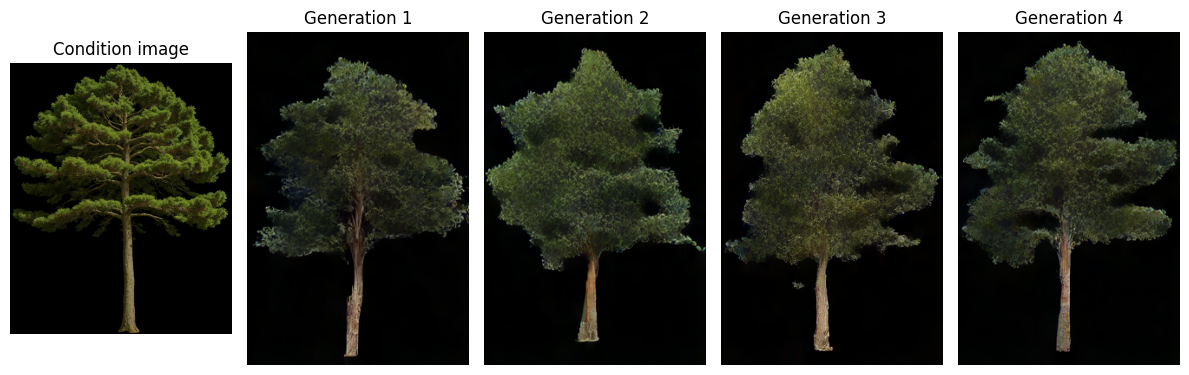

In [58]:
import random
from time import sleep
import PIL.Image
from matplotlib import pyplot as plt
from kemsekov_torch.utils import PadToMultiple

def sample(
    guidance,
    condition_on : str | PIL.Image.Image | None,
    images_count,
    image_shape, 
    x0 = None,
    inverse=False,
    steps = 32,
    churn_scale=0.001,
    random_state=None,
    device='cuda',
    dtype=torch.bfloat16
):
    if random_state is not None:
        g = torch.Generator(device)
        g.manual_seed(random_state)
    else:
        g = None
    
    if x0 is None:
        image_shape = [v//8 for v in image_shape]
        x0 = torch.randn([images_count,4]+image_shape,generator=g,device=device)
    
    if isinstance(x0,PIL.Image.Image):
        t = T.ToTensor()(x0.convert("RGB"))
        t = PadToMultiple(64)(t)
        x0 = vae.encode(t)[[0]*images_count]
    
    if isinstance(condition_on,str) and condition_on in embedds_cache:
        clip_emb=embedds_cache[condition_on].to(device)
    else:
        if condition_on is None or guidance==0:
            clip_emb=torch.zeros((1,512)).to(device)
        else:
            print("compute")
            if isinstance(condition_on,PIL.Image.Image):
                clip_emb = c.image_to_embedding(condition_on)[None,:].to(device)
            else:
                clip_emb = c.text_to_embedding(condition_on)[None,:].to(device)
                embedds_cache[condition_on]=clip_emb.cpu()
            
    context=clip_emb[[0]*images_count]

    m = model.to(device)
    def run_model(xt,t):
        
        pred_no_cls = m(xt,(context*0).to(dtype),t)
        if guidance==0:
            return pred_no_cls.float()
        pred_cls =  m(xt,context,t)
        
        a = pred_cls.flatten(1)
        b = pred_no_cls.flatten(1)
        scale = (a * b).sum(-1) / b.pow(2).sum(-1)
        scale = scale[:,None,None]
        
        # total = pred_no_cls+guidance*(pred_cls-pred_no_cls)
        total = (1-guidance)*scale*pred_no_cls+guidance*pred_cls
        return total

    with torch.autocast(device,dtype=dtype):
        
        sample = fm.sample(
            run_model,
            x0,
            steps,
            churn_scale=churn_scale,
            device=device,
            inverse=inverse,
        )

    return sample.to(device)

condition_on = PIL.Image.open('./samples/oak.png')
model = load_last_checkpoint(model,path).eval()
images_count=4
sample_ = sample(
    guidance=2,
    condition_on=condition_on,
    # condition_on='orange',
    images_count=images_count,
    image_shape=(256+128,256),
    steps=24,
    device='cuda',
    # x0 = PIL.Image.open('./samples/GREEN.png'),
    # x0 = x0,
    # inverse=False
    # churn_scale=0.001,
    # random_state=153
)

sample_dec = vae.decode(sample_).clamp(0,1).to('cpu')

sq = int(images_count**0.5)
plt.figure(figsize=(12,8))
plt.subplot(1,images_count+1,1)
plt.imshow(condition_on)
plt.title(f"Condition image")
plt.axis('off')

for i,v in enumerate(sample_dec):
    plt.subplot(1,images_count+1,i+2)
    plt.imshow(T.ToPILImage()(v))
    plt.title(f"Generation {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# x0 = sample_

torch.Size([4, 4, 96, 64])

In [10]:
import os
import tkinter as tk
from tkinter import ttk, filedialog
from tkinter import Canvas
from PIL import Image, ImageTk
from tkinter import messagebox

class ImageGeneratorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Image Generator")

        # Main frame split: left (canvas) and right (controls)
        self.main_frame = tk.Frame(root)
        self.main_frame.pack(fill=tk.BOTH, expand=True)

        # Left: image canvas with scrollbar
        self.canvas_frame = tk.Frame(self.main_frame)
        self.canvas_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        self.canvas = Canvas(self.canvas_frame, bg="white")
        self.scrollbar = ttk.Scrollbar(self.canvas_frame, orient=tk.HORIZONTAL, command=self.canvas.xview)
        self.canvas.configure(xscrollcommand=self.scrollbar.set)

        self.scrollbar.pack(side=tk.BOTTOM, fill=tk.X)
        self.canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        self.images_container = tk.Frame(self.canvas)
        self.image_container = self.canvas.create_window((0, 0), window=self.images_container, anchor="nw")

        # --- Right ---
        self.controls_frame = tk.Frame(self.main_frame, padx=10, pady=10)
        self.controls_frame.pack(side=tk.RIGHT, fill=tk.Y)

        self.fixed_controls = tk.Frame(self.controls_frame, padx=5, pady=5)
        self.fixed_controls.pack(side=tk.TOP, fill=tk.X)

        length = 300

        # Guidance
        tk.Label(self.fixed_controls, text="Guidance").pack(anchor="w")
        self.guidance_slider = tk.Scale(self.fixed_controls, from_=0, to=5, resolution=0.1,
                                        orient=tk.HORIZONTAL, length=length)
        self.guidance_slider.set(1)
        self.guidance_slider.pack(anchor="w")

        # Images count (scrollable 1–8)
        tk.Label(self.fixed_controls, text="Images Count").pack(anchor="w")
        self.images_count_slider = tk.Scale(self.fixed_controls, from_=1, to=8, resolution=1,
                                            orient=tk.HORIZONTAL, length=length)
        self.images_count_slider.set(1)
        self.images_count_slider.pack(anchor="w")

        # Width (scrollable, auto-adjust to divisible by 32)
        tk.Label(self.fixed_controls, text="Width").pack(anchor="w")
        self.width_slider = tk.Scale(self.fixed_controls, from_=128, to=512, resolution=64,
                                     orient=tk.HORIZONTAL, length=length)
        self.width_slider.set(512)
        self.width_slider.pack(anchor="w")

        # Height (scrollable, auto-adjust)
        tk.Label(self.fixed_controls, text="Height").pack(anchor="w")
        self.height_slider = tk.Scale(self.fixed_controls, from_=128, to=512, resolution=64,
                                      orient=tk.HORIZONTAL, length=length)
        self.height_slider.set(256)
        self.height_slider.pack(anchor="w")

        # Steps (scrollable 4–32)
        tk.Label(self.fixed_controls, text="Steps").pack(anchor="w")
        self.steps_slider = tk.Scale(self.fixed_controls, from_=4, to=32, resolution=1,
                                     orient=tk.HORIZONTAL, length=length)
        self.steps_slider.set(24)
        self.steps_slider.pack(anchor="w")

        # Smoothness (scrollable 0–0.01)
        tk.Label(self.fixed_controls, text="Smoothness").pack(anchor="w")
        self.smoothness_slider = tk.Scale(self.fixed_controls, from_=0, to=0.01, resolution=0.0001,
                                          orient=tk.HORIZONTAL, length=length)
        self.smoothness_slider.set(0.001)
        self.smoothness_slider.pack(anchor="w")

        # Reference Image selection
        tk.Label(self.fixed_controls, text="Reference Image").pack(anchor="w")
        self.reference_image_path_var = tk.StringVar()
        self.reference_image_entry = tk.Entry(self.fixed_controls,
                                              textvariable=self.reference_image_path_var, width=40)
        self.reference_image_entry.pack(anchor="w")

        self.ref_button = tk.Button(self.fixed_controls, text="Select Image",
                                    command=self.select_reference_image)
        self.ref_button.pack(anchor="w", pady=5)

        self.path_to_referenec_image = None

        # Generate / Save
        self.generate_btn = tk.Button(self.fixed_controls, text="Generate", command=self.generate_image)
        self.generate_btn.pack(pady=5, fill=tk.X)

        self.save_btn = tk.Button(self.fixed_controls, text="Save", command=self.save_images)
        self.save_btn.pack(pady=5, fill=tk.X)

        # Container for images
        self.generated_images = []
        self.pil_images = []

    # ---------------------------------------------------------------------
    def select_reference_image(self):
        filetypes = [
            ("Image files", "*.png *.jpg *.jpeg *.webp"),
            ("PNG files", "*.png"),
            ("JPEG files", "*.jpg *.jpeg"),
            ("WebP files", "*.webp"),
            ("All files", "*.*")
        ]

        filepath = filedialog.askopenfilename(
            title="Select reference image",
            filetypes=filetypes
        )

        if filepath:
            self.path_to_referenec_image = filepath
            self.reference_image_path_var.set(filepath)
            print(f"Selected reference image: {filepath}")

    # ---------------------------------------------------------------------
    def generate_image(self):
        try:
            torch.cuda.empty_cache()
        except: pass
        for w in self.images_container.winfo_children():
            w.destroy()
        self.generated_images.clear()
        self.pil_images.clear()

        guidance = self.guidance_slider.get()
        count = int(self.images_count_slider.get())
        churn_scale = float(self.smoothness_slider.get())
        steps = int(self.steps_slider.get())

        width = int(self.width_slider.get())
        height = int(self.height_slider.get())

        # Always divisible by 32 because resolution=32 ensures it
        try:
            samples = sample(
                guidance=guidance,
                reference_image=self.path_to_referenec_image,
                images_count=count,
                image_shape=(width, height),
                steps=steps,
                churn_scale=churn_scale
            )
        except torch.OutOfMemoryError:
            messagebox.showwarning(
                "Out of VRAM",
                "Not enough GPU memory to generate the images.\n\n"
                "Try lowering width/height, steps, or image count."
            )
            return

        for i, s in enumerate(samples):
            img = T.ToPILImage()(s)
            self.pil_images.append(img)
            tk_img = ImageTk.PhotoImage(img)
            self.generated_images.append(tk_img)

            lbl = tk.Label(self.images_container, image=tk_img)

            # Layout selection
            if height > width:
                # Vertical (top → down)
                lbl.grid(row=i%4, column=i//4, padx=5, pady=5)
            else:
                # Horizontal (left → right)
                lbl.grid(row=i//4, column=i%4, padx=5, pady=5)

        self.canvas.update_idletasks()
        self.canvas.config(scrollregion=self.canvas.bbox("all"))

    # ---------------------------------------------------------------------
    def save_images(self):
        if not self.pil_images:
            print("No images to save!")
            return

        folder = filedialog.askdirectory(title="Select folder to save images")
        if not folder:
            return

        for idx, img in enumerate(self.pil_images):
            path = os.path.join(folder, f"image_{idx+1}.png")
            img.save(path)
            print(f"Saved {path}")

# ---------------------------------------------------------------------
if __name__ == "__main__":
    root = tk.Tk()
    root.geometry("1600x1200")
    app = ImageGeneratorApp(root)
    root.mainloop()


torch.Size([8, 32, 32])